<center><img src = 'https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true'  width="400" height="200"></center>

# **Machine Learning Project Capstone Group 1007**


### **Table of Contents**

1. [Introduction](#section1)<br>
     
2. [Project Description](#section2)<br>
     
3. [Problem Statement](#section3)<br>     

4. [Problem Analysis](#section4)<br> 

5. [Data Pre Processing](#section5)<br> 

6. [Exploratory Data Analysis](#section6)<br> 

7. [Profiling](#section7)<br> 

8. [Post Profiling EDA Analysis](#section8)<br> 

9. [Conclusion/Summarization](#section9)<br>

10. [Actionable Insight](#section10)<br>

<a id=section1></a>
## **1. Introduction**

For an HR Department at a software company who want to try a new initiative to retain employees is planning to gain insights using data to predict whether an employee is likely to leave.
Once these employees are identified, HR can be more proactive in reaching out to them before it's too late.
They only want to deal with the data that is related to permanent employees.

Currently, when an employee leaves, he or she is taken an interview with the name “exit interview” and shares reasons for leaving. The HR Department then tries and learns insights from the interview and makes changes accordingly.



<a id=section2></a>
## **2. Project Description**

This current approach suffers with problems is that it's too haphazard. The quality of insight gained from an interview depends heavily on the skill of the interviewer.
The second problem is these insights can't be aggregated and interlaced across all employees who have left.
The third is that it is too late by the time the proposed policy changes take effect.






<a id=section3></a>
## **3. Problem Statement**
The HR department want to supplement their exit interviews with a more proactive approach.

<a id=section401></a>
## **4. Importing Packages**


In [ ]:
#installing mysql connector
!pip install mysql.connector

     |████████████████████████████████| 11.9MB 262kB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp36-cp36m-linux_x86_64.whl size=247949 sha256=d3b853c4b46988ad3c99e20dd7e35b1eb2d9454e6722711443bbca1081c86057
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql.connector


In [ ]:
import mysql.connector as mysql
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
cnx = mysql.connect(user='student', password='student',
                              host='cpanel.insaid.co',
                              database='Capstone2')

In [ ]:
#To download data in csv files enable it
download=True

In [ ]:
table_names_with_query = { 'departmentDf': 'select * from department_data', 
                          'EmployeeDetailsDf':'select * from employee_details_data',
                          'EmployeeDf': "select * from employee_data"}

In [ ]:
if download:
  for name, query in table_names_with_query.items():
    cursor = cnx.cursor()
    cursor.execute(query)
    with open(name+'.csv', 'w', newline='',encoding="utf-8") as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow([i[0] for i in cursor.description]) 
      writer.writerows(cursor.fetchall())
    cursor.close()

<a id=section5></a>
## **5. Loading Data**

<a id=section501></a>
## **5.1 Employee Details**

In [ ]:
EmployeeDetailsDf = pd.read_csv('/content/EmployeeDetailsDf.csv')
EmployeeDetailsDf.head()

,employee_id,age,gender,marital_status
0,113558,43,Male,Married
1,112256,24,Female,Unmarried
2,112586,22,Female,Unmarried
3,108071,36,Male,Married
4,116915,38,Male,Married


In [ ]:
EmployeeDetailsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14245 entries, 0 to 14244
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   employee_id     14245 non-null  int64 
 1   age             14245 non-null  int64 
 2   gender          14245 non-null  object
 3   marital_status  14245 non-null  object
dtypes: int64(2), object(2)
memory usage: 445.3+ KB


In [ ]:
# Dimension of the Employee Details
EmployeeDetailsDf.shape

(14245, 4)

In [ ]:
#Check Missing Values in Employee Details dataset
EmployeeDetailsDf.isnull().sum()

employee_id       0
age               0
gender            0
marital_status    0
dtype: int64

Employee Details Df data have 4 features:

1. employee-id which will be unique
2. Employee Details dataset has no missing values

<a id=section502></a>
## **5.2 Employee Df**

In [ ]:
EmployeeDf = pd.read_csv('/content/EmployeeDf.csv')
EmployeeDf.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.0,NaN,NaN,0.866838,6,NaN,medium,0.134415,Left,4.0,124467
1,134.0,NaN,NaN,0.555718,2,NaN,low,0.511041,Left,3.0,112210
2,156.0,D00-SS,1.0,0.474082,2,NaN,medium,0.405101,Left,3.0,126150
3,256.0,D00-SP,NaN,0.961360,6,NaN,low,0.152974,Left,4.0,125346
4,146.0,D00-SS,NaN,0.507349,2,NaN,medium,0.434845,Left,3.0,113707


Target variable
- 'status' – Current employment status (Employed / Left)

Features

- 'department' – Department employees belong(ed) to
- 'salary' – Salary level relative to rest of their department
- 'tenure' – Number of years at the company
- 'recently_promoted' – Was the employee promoted in the last 3 years?
- 'n_projects' – Number of projects employee is staffed on
- 'avg_monthly_hrs' – Average number of hours worked per month
Mutual evaluation information
- 'satisfaction' – Score for employee’s satisfaction with the company (higher is better)
- 'last_evaluation' – Score for most recent evaluation of employee (higher is better)
- 'filed_complaint' – Has the employee filed a formal complaint in the last 3 years?

In [ ]:
EmployeeDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  float64
 1   department         13443 non-null  object 
 2   filed_complaint    2046 non-null   float64
 3   last_evaluation    12663 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  297 non-null    float64
 6   salary             14150 non-null  object 
 7   satisfaction       14000 non-null  float64
 8   status             14150 non-null  object 
 9   tenure             14000 non-null  float64
 10  employee_id        14150 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 1.2+ MB


In [ ]:
# Dimension of the Employee Df
EmployeeDf.shape

(14150, 11)

In [ ]:
#Check Missing Values in Employee dataset
EmployeeDf.isnull().sum()

avg_monthly_hrs          0
department             707
filed_complaint      12104
last_evaluation       1487
n_projects               0
recently_promoted    13853
salary                   0
satisfaction           150
status                   0
tenure                 150
employee_id              0
dtype: int64

In [ ]:
# Column datatypes
EmployeeDf.dtypes

avg_monthly_hrs      float64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
employee_id            int64
dtype: object

Make sure all the data types make sense and none seems incorrect

<a id=section503></a>
## **5.3 Department Df**

In [ ]:
departmentDf = pd.read_csv('/content/departmentDf.csv')
departmentDf.head()

,dept_id,dept_name,dept_head
0,D00-IT,IT,Henry Adey
1,D00-SS,Sales,Edward J Bayley
2,D00-TP,Temp,Micheal Zachrey
3,D00-ENG,Engineering,Sushant Raghunathan K
4,D00-SP,Support,Amelia Westray


In [ ]:
departmentDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dept_id    11 non-null     object
 1   dept_name  11 non-null     object
 2   dept_head  11 non-null     object
dtypes: object(3)
memory usage: 392.0+ bytes


In [ ]:
# Dimension of the Department Df
departmentDf.shape

(11, 3)

In [ ]:
#Check Missing Values in Department dataset
departmentDf.isnull().sum()

dept_id      0
dept_name    0
dept_head    0
dtype: int64

> Using ```info```we get following insights for all 3 datasets 
- For Department Table, there are 11 unique Departments
- 14245 Employees in the Employee Details table whereas 14150 employees admistrative information is populated in the Employees Admistrative table.
- In the employee administrative table there few columns like filed complaint, recently Promoted information is not populated for all rows
- Employee Id is common between Employee details and employee Administrative table.



**Observations**
*  Null values in Filed Complaint and Recently Promoted column. We need to replace the NAN with valid values like 0 for not Promoted or Not filed complaints columns

<a id=section6></a>
## **6. Data Preprocessing**

 ### **6.1.1 Treating missing  values for Promoted and filed Complaints and Last Evaluation columns**

In [ ]:
EmployeeDf.fillna({'filed_complaint': 0,'recently_promoted': 0, 'last_evaluation': 0}, inplace = True)

In [ ]:
# Describe Employee dataset
EmployeeDf.describe(include= "all")

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
count,14150.000000,13443,14150.000000,14150.000000,14150.000000,14150.000000,14150,14000.000000,14150,14000.000000,14150.000000
unique,NaN,12,NaN,NaN,NaN,NaN,3,NaN,2,NaN,NaN
top,NaN,D00-SS,NaN,NaN,NaN,NaN,low,NaN,Employed,NaN,NaN
freq,NaN,3905,NaN,NaN,NaN,NaN,6906,NaN,10784,NaN,NaN
mean,199.994346,NaN,0.144594,0.642904,3.778304,0.020989,NaN,0.621212,NaN,3.499357,112080.750247
std,50.833697,NaN,0.351703,0.274512,1.250162,0.143354,NaN,0.250482,NaN,1.462584,8748.202856
min,49.000000,NaN,0.000000,0.000000,1.000000,0.000000,NaN,0.040058,NaN,2.000000,0.000000
25%,155.000000,NaN,0.000000,0.522031,3.000000,0.000000,NaN,0.450356,NaN,3.000000,105772.500000
50%,199.000000,NaN,0.000000,0.683553,4.000000,0.000000,NaN,0.652394,NaN,3.000000,111291.500000
75%,245.000000,NaN,0.000000,0.857037,5.000000,0.000000,NaN,0.824926,NaN,4.000000,116650.750000


### **6.1.2 Treating Missing Department and incorrect Department value**

In [ ]:
EmployeeDf['department'].mode()[0]

'D00-SS'

In [ ]:
# Replace the missing department values of Employee dataset with Mode value
EmployeeDf['department'].fillna('D00-SS', inplace=True)



In [ ]:
EmployeeDf['department'].unique()

array(['D00-SS', 'D00-SP', 'D00-MT', 'D00-PD', 'D00-IT', 'D00-AD',
       'D00-MN', 'D00-ENG', 'D00-PR', 'D00-TP', 'D00-FN', '-IT'],
      dtype=object)

In [ ]:
EmployeeDf.replace({'-IT': "D00-IT"}, inplace = True)

In [ ]:
EmployeeDf['department'].unique()

array(['D00-SS', 'D00-SP', 'D00-MT', 'D00-PD', 'D00-IT', 'D00-AD',
       'D00-MN', 'D00-ENG', 'D00-PR', 'D00-TP', 'D00-FN'], dtype=object)

In [ ]:
EmployeeDf.isnull().sum()

avg_monthly_hrs        0
department             0
filed_complaint        0
last_evaluation        0
n_projects             0
recently_promoted      0
salary                 0
satisfaction         150
status                 0
tenure               150
employee_id            0
dtype: int64

### **6.1.3 Checking Missing value for satisfication column of EmployeeDf**

In [ ]:
EmployeeDf[EmployeeDf["satisfaction"].isna()]

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
44,125.0,D00-TP,0.0,0.0,3,0.0,medium,NaN,Left,NaN,120360
245,124.0,D00-TP,0.0,0.0,3,0.0,low,NaN,Left,NaN,116012
251,119.0,D00-TP,0.0,0.0,2,0.0,medium,NaN,Left,NaN,116287
414,126.0,D00-TP,0.0,0.0,2,0.0,low,NaN,Left,NaN,115235
468,65.0,D00-TP,0.0,0.0,1,0.0,high,NaN,Left,NaN,122769
...,...,...,...,...,...,...,...,...,...,...,...
13741,122.0,D00-TP,0.0,0.0,2,0.0,medium,NaN,Employed,NaN,111990
13774,49.0,D00-TP,0.0,0.0,2,0.0,low,NaN,Employed,NaN,148021
13841,97.0,D00-TP,1.0,0.0,1,0.0,medium,NaN,Employed,NaN,116171
13905,132.0,D00-TP,0.0,0.0,2,0.0,medium,NaN,Left,NaN,106482


In [ ]:
# file the missing values for satisfaction with Mean value
EmployeeDf['satisfaction'].fillna(EmployeeDf['satisfaction'].mean(), inplace=True)

### **6.1.4 Checking Missing value for Tenure column of EmployeeDf**

In [ ]:
# Code to filter out state specific rows
EmployeeDf[EmployeeDf["tenure"].isna()]

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
44,125.0,D00-TP,0.0,0.0,3,0.0,medium,0.621212,Left,NaN,120360
245,124.0,D00-TP,0.0,0.0,3,0.0,low,0.621212,Left,NaN,116012
251,119.0,D00-TP,0.0,0.0,2,0.0,medium,0.621212,Left,NaN,116287
414,126.0,D00-TP,0.0,0.0,2,0.0,low,0.621212,Left,NaN,115235
468,65.0,D00-TP,0.0,0.0,1,0.0,high,0.621212,Left,NaN,122769
...,...,...,...,...,...,...,...,...,...,...,...
13741,122.0,D00-TP,0.0,0.0,2,0.0,medium,0.621212,Employed,NaN,111990
13774,49.0,D00-TP,0.0,0.0,2,0.0,low,0.621212,Employed,NaN,148021
13841,97.0,D00-TP,1.0,0.0,1,0.0,medium,0.621212,Employed,NaN,116171
13905,132.0,D00-TP,0.0,0.0,2,0.0,medium,0.621212,Left,NaN,106482


In [ ]:
# file the missing values for tenure with Mean value
EmployeeDf['tenure'].fillna(EmployeeDf['tenure'].mean(), inplace=True)

In [ ]:
EmployeeDf.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.0,D00-SS,0.0,0.866838,6,0.0,medium,0.134415,Left,4.0,124467
1,134.0,D00-SS,0.0,0.555718,2,0.0,low,0.511041,Left,3.0,112210
2,156.0,D00-SS,1.0,0.474082,2,0.0,medium,0.405101,Left,3.0,126150
3,256.0,D00-SP,0.0,0.961360,6,0.0,low,0.152974,Left,4.0,125346
4,146.0,D00-SS,0.0,0.507349,2,0.0,medium,0.434845,Left,3.0,113707


***Observations***
*   There are missing values in Employee administrative details table.
- For last evaluation column we have 10.5% Missing Data and for department 5 % missing data and for tenure and Satisfaction survey 1% missing data.
- We need to treat the last evaluation data and Department column as the missing data % is pretty high. For tenure and satisifaction survey, we can safely assume that 1% employees are new joines and we can either prefill tenure as 0 and satisfaction as 1.or we can drop these rows.

In [ ]:
# Summarize numerical features
EmployeeDf.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,employee_id
count,14150.000000,14150.000000,14150.000000,14150.000000,14150.000000,14150.000000,14150.000000,14150.000000
mean,199.994346,0.144594,0.642904,3.778304,0.020989,0.621212,3.499357,112080.750247
std,50.833697,0.351703,0.274512,1.250162,0.143354,0.249151,1.454811,8748.202856
min,49.000000,0.000000,0.000000,1.000000,0.000000,0.040058,2.000000,0.000000
25%,155.000000,0.000000,0.522031,3.000000,0.000000,0.452824,3.000000,105772.500000
50%,199.000000,0.000000,0.683553,4.000000,0.000000,0.648124,3.000000,111291.500000
75%,245.000000,0.000000,0.857037,5.000000,0.000000,0.822965,4.000000,116650.750000
max,310.000000,1.000000,1.000000,7.000000,1.000000,1.000000,10.000000,148988.000000


## **6.1.4 Checking for Duplicate data in EmployeeDf**

In [ ]:
EmployeeDfDuplicate = EmployeeDf[EmployeeDf.duplicated('employee_id',keep = False)].sort_values(["employee_id"])


In [ ]:
# Drop duplicate rows
EmployeeDf.drop_duplicates(keep = "first",inplace = True)

In [ ]:
## Check after removing duplicate rows.
EmployeeDf[EmployeeDf.duplicated('employee_id',keep = False)].sort_values(["employee_id"])

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
34,284.0,D00-SS,0.0,0.852702,6,0.0,low,0.069168,Left,4.0,0
304,264.0,D00-ENG,0.0,0.774554,6,0.0,low,0.110974,Left,4.0,0
1234,129.0,D00-SP,0.0,0.402660,2,0.0,medium,0.437359,Left,3.0,0
11304,167.0,D00-SS,0.0,0.880053,5,0.0,low,0.682140,Employed,3.0,0
12304,259.0,D00-ENG,0.0,0.505883,5,0.0,low,0.631046,Employed,4.0,0


**Observation**
- Even after removing duplicate rows, there are still 5 rows with employee Id = 0. Let's process those rows

In [ ]:
## filter the rows with employee Id = 0
EmployeeDf = EmployeeDf[EmployeeDf['employee_id'] != 0]  

In [ ]:
 # check if still there is any duplicate
EmployeeDf[EmployeeDf.duplicated('employee_id',keep = False)].sort_values(["employee_id"]) 

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id


## **6.1.6 Fixing datatype filed_complaint and recently_promoted column**
From the initial data, we can see that filed_complaint and recently_promoted column are float. For our model these two columns should be categorically. hence let's convert this in to int and then change this to string

### **6.1.6.1 Fix the datatype for filed_complaint and recently_promoted column in EmployeeDF**

In [ ]:
EmployeeDf['recently_promoted'] = EmployeeDf['recently_promoted'].astype(int)
EmployeeDf['filed_complaint'] = EmployeeDf['filed_complaint'].astype(int)
EmployeeDf

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.0,D00-SS,0,0.866838,6,0,medium,0.134415,Left,4.0,124467
1,134.0,D00-SS,0,0.555718,2,0,low,0.511041,Left,3.0,112210
2,156.0,D00-SS,1,0.474082,2,0,medium,0.405101,Left,3.0,126150
3,256.0,D00-SP,0,0.961360,6,0,low,0.152974,Left,4.0,125346
4,146.0,D00-SS,0,0.507349,2,0,medium,0.434845,Left,3.0,113707
...,...,...,...,...,...,...,...,...,...,...,...
14116,141.0,D00-SS,0,0.537866,3,0,low,0.610841,Employed,3.0,100833
14117,168.0,D00-SS,0,0.643553,3,0,low,0.489559,Employed,3.0,118090
14118,257.0,D00-SP,0,0.000000,3,0,medium,0.944942,Employed,3.0,106064
14119,242.0,D00-IT,0,0.836603,4,0,low,0.740136,Employed,2.0,113083


In [ ]:
# Convert this in Categorical column
EmployeeDf['recently_promoted'] = EmployeeDf['recently_promoted'].astype(str) 
EmployeeDf['filed_complaint'] = EmployeeDf['filed_complaint'].astype(str)
EmployeeDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14116 entries, 0 to 14120
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14116 non-null  float64
 1   department         14116 non-null  object 
 2   filed_complaint    14116 non-null  object 
 3   last_evaluation    14116 non-null  float64
 4   n_projects         14116 non-null  int64  
 5   recently_promoted  14116 non-null  object 
 6   salary             14116 non-null  object 
 7   satisfaction       14116 non-null  float64
 8   status             14116 non-null  object 
 9   tenure             14116 non-null  float64
 10  employee_id        14116 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ MB


### **6.1.7 Merge the Data from EmployeeDetails and EmployeeDF**

In [ ]:
## Merging the Employee data
Employee=pd.merge(EmployeeDf,EmployeeDetailsDf,how="left",on="employee_id")
# EmployeeDept=pd.merge(Employee,departmentDf,left_on="department",right_on='dept_id',how="left") 
# Urvi: No need to Merge the Dept in the final table because we have department Id which should suffice for our Model

In [ ]:
EmployeeDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14116 entries, 0 to 14120
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14116 non-null  float64
 1   department         14116 non-null  object 
 2   filed_complaint    14116 non-null  object 
 3   last_evaluation    14116 non-null  float64
 4   n_projects         14116 non-null  int64  
 5   recently_promoted  14116 non-null  object 
 6   salary             14116 non-null  object 
 7   satisfaction       14116 non-null  float64
 8   status             14116 non-null  object 
 9   tenure             14116 non-null  float64
 10  employee_id        14116 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ MB


In [ ]:
Employee.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id,age,gender,marital_status
0,246.0,D00-SS,0,0.866838,6,0,medium,0.134415,Left,4.0,124467,42,Female,Married
1,134.0,D00-SS,0,0.555718,2,0,low,0.511041,Left,3.0,112210,23,Female,Unmarried
2,156.0,D00-SS,1,0.474082,2,0,medium,0.405101,Left,3.0,126150,24,Female,Unmarried
3,256.0,D00-SP,0,0.961360,6,0,low,0.152974,Left,4.0,125346,51,Female,Married
4,146.0,D00-SS,0,0.507349,2,0,medium,0.434845,Left,3.0,113707,23,Female,Unmarried


In [ ]:
Employee.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14116 entries, 0 to 14115
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14116 non-null  float64
 1   department         14116 non-null  object 
 2   filed_complaint    14116 non-null  object 
 3   last_evaluation    14116 non-null  float64
 4   n_projects         14116 non-null  int64  
 5   recently_promoted  14116 non-null  object 
 6   salary             14116 non-null  object 
 7   satisfaction       14116 non-null  float64
 8   status             14116 non-null  object 
 9   tenure             14116 non-null  float64
 10  employee_id        14116 non-null  int64  
 11  age                14116 non-null  int64  
 12  gender             14116 non-null  object 
 13  marital_status     14116 non-null  object 
dtypes: float64(4), int64(3), object(7)
memory usage: 1.6+ MB


**Observations**
- The final data set have non null values in all columns

In [ ]:
total = Employee.isnull().sum().sort_values(ascending=False)
percent = ((Employee.isnull().sum()/Employee.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])     
missing_data.head(10)

,Total,Percent
marital_status,0,0.0
gender,0,0.0
age,0,0.0
employee_id,0,0.0
tenure,0,0.0
status,0,0.0
satisfaction,0,0.0
salary,0,0.0
recently_promoted,0,0.0
n_projects,0,0.0


In [ ]:
#Employee.drop(['dept_id'],axis=1,inplace=True) 
# We should not drop department Id as it will required for Model because are Test data submittion file from INSAID contains Dept Id

<a id=section7></a>
# **7. Exploratory Data Analysis**

**Exploratory Data Analysis(EDA)** is an **approach to analyzing data sets** to **summarize** their **main characteristics**, often with **visual methods**.

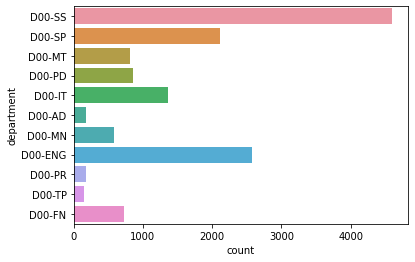

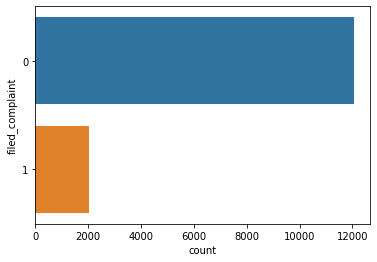

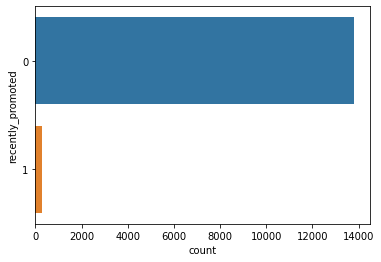

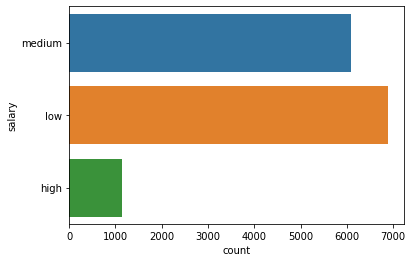

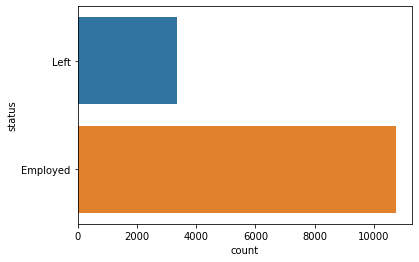

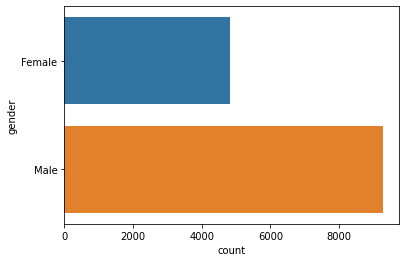

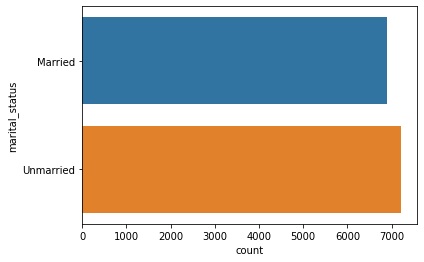

In [ ]:
## Visualizing the countplot for the columns with "object" data types
categorical_cols=Employee.select_dtypes(exclude='float').select_dtypes(exclude='int64').columns
for i in categorical_cols:
    sns.countplot(y=i,data=Employee)
    plt.show()

##### Observations:
- More than 4000 employees are from Sales
- 23% of available data is for employees who have left.



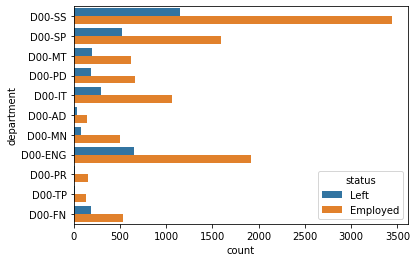

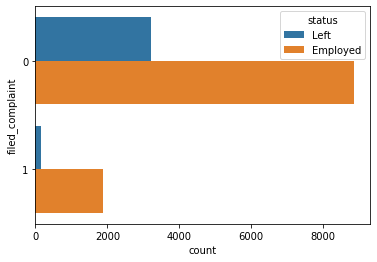

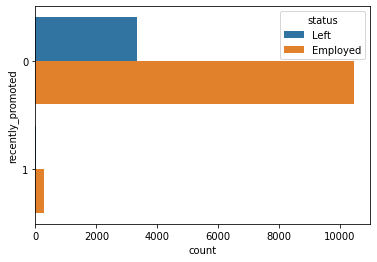

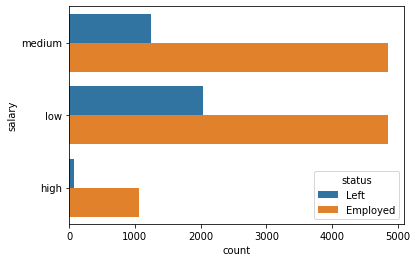

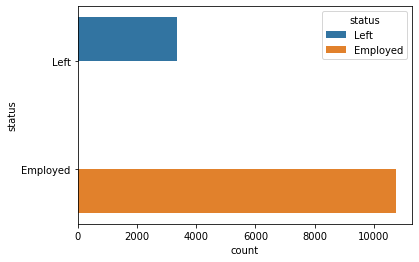

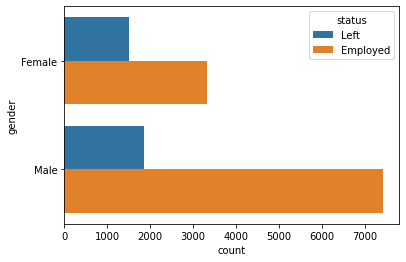

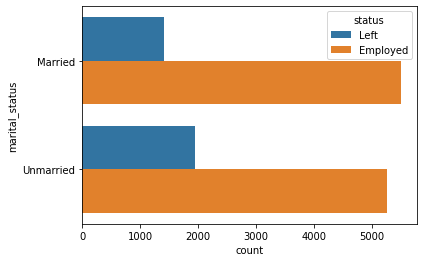

In [ ]:
## Visualizing the countplot for the columns with "object" data types
categorical_cols=Employee.select_dtypes(exclude='float').select_dtypes(exclude='int64').columns
for i in categorical_cols:
    sns.countplot(y=i,hue='status',data=Employee)
    plt.show()

##### Observation
- Attrition is highest in D00-FN ~27% and D00-PR has lowest ~9%

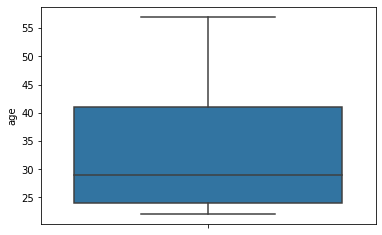

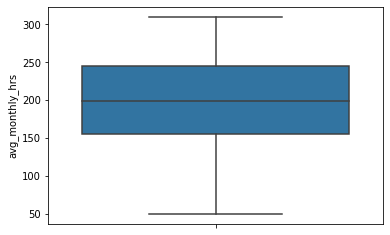

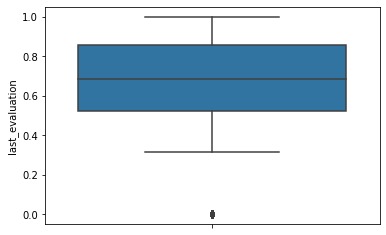

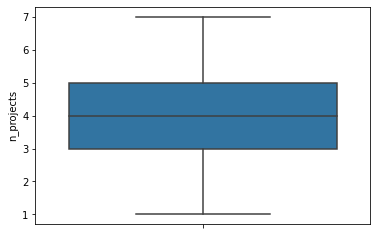

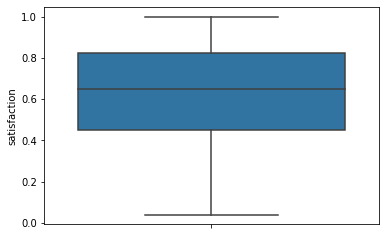

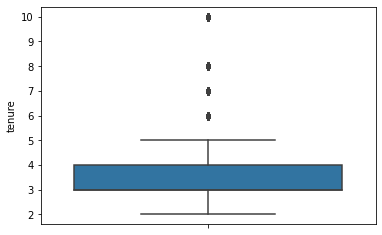

In [ ]:
## Visualizing the countplot for the columns with "int and float" data types
numerical_cols=['age','avg_monthly_hrs','last_evaluation', 'n_projects','satisfaction','tenure']
for i in numerical_cols:
    sns.boxplot(y=i,data=Employee)
    plt.show()

##### Observation
- 70% of population is within 41 years of age
- 50% of population is evaluated above 0.7
- 50% of population is statisfied above 0.6
- Most of the population is with tenure within 5 years

## Distribution of Numeric features of Employee data

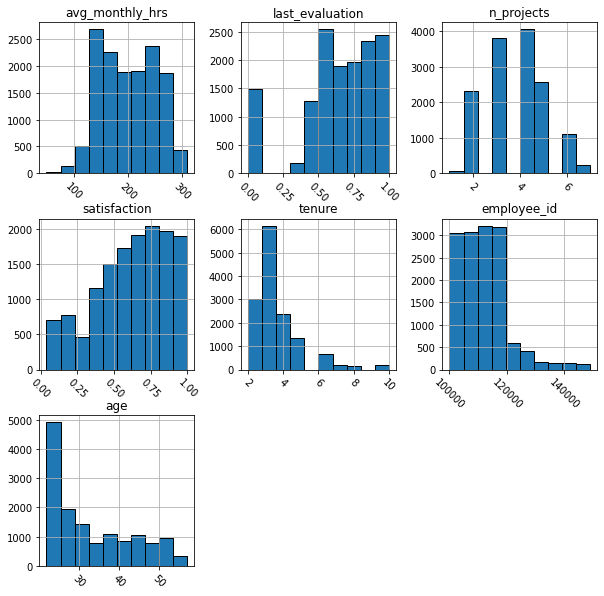

In [ ]:
# Plot histogram grid
Employee.hist(figsize=(10,10), xrot=-45, edgecolor='black')
plt.show()


Observations:

- 1.'filed_compliant' and 'recently_promoted' must be binary indicator variables.
- 2.'last_evaluation' ranges approx from 0.4 to 1
- 3.'satisfaction' ranges approx from 0 to 1
- 4.'tenure' for most of the employees is less than or equal to 5 years
- 5.'n_projects' ranges between 2 to 6

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


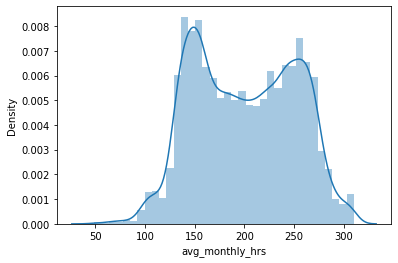

In [ ]:
#plot KDE for average monthly hours
sns.distplot(Employee['avg_monthly_hrs'])


- Some employees work for around 150 hrs/month i.e. 37.5 hrs/week which is reasonable.
- However there are employees who work for 250 hrs/month i.e. 62.5 hrs/week, which turns out to be 12.5 hrs/day which is big number

## Distribution of Categorical features

In [ ]:
# Summarize categorical features
Employee.describe(include=['object'])

,department,filed_complaint,recently_promoted,salary,status,gender,marital_status
count,14116,14116,14116,14116,14116,14116,14116
unique,11,2,2,3,2,2,2
top,D00-SS,0,0,low,Employed,Male,Unmarried
freq,4601,12075,13819,6889,10761,9287,7211


In [ ]:
Employee['salary'].value_counts()

low       6889
medium    6086
high      1141
Name: salary, dtype: int64

In [ ]:
Employee['status'].value_counts()

Employed    10761
Left         3355
Name: status, dtype: int64

<a id=section703></a>
### 7.3 Find Correlated Columns
> Explore the correlation between all columns and accordingly select the columns for our model .
Establishing __coorelation__ between all the features using __heatmap__

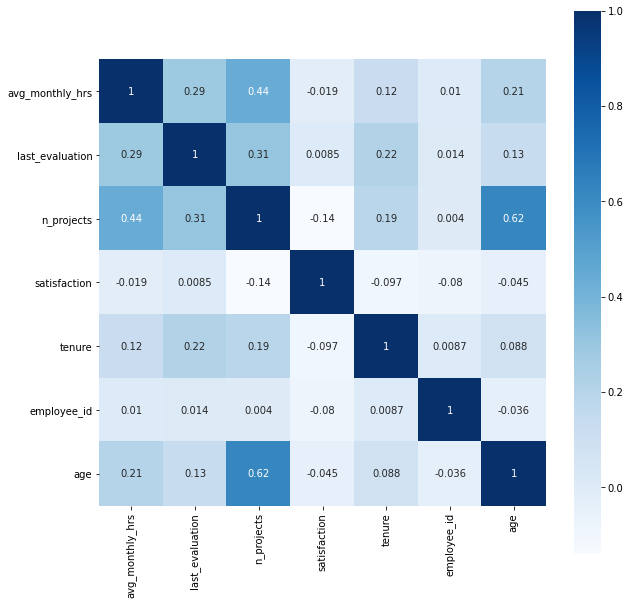

In [ ]:
features_correlation = Employee.corr() ## Generate Correlation
plt.figure(figsize=(10 ,10))
sns.heatmap(features_correlation,vmax=1,square=True,annot=True,cmap='Blues')
plt.show()

**Observation**
- There is correlation between Avg monthly hrs and files complaint and Satisfaction. It means employees who are working for more hours have filed complaints and are less satisfied.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


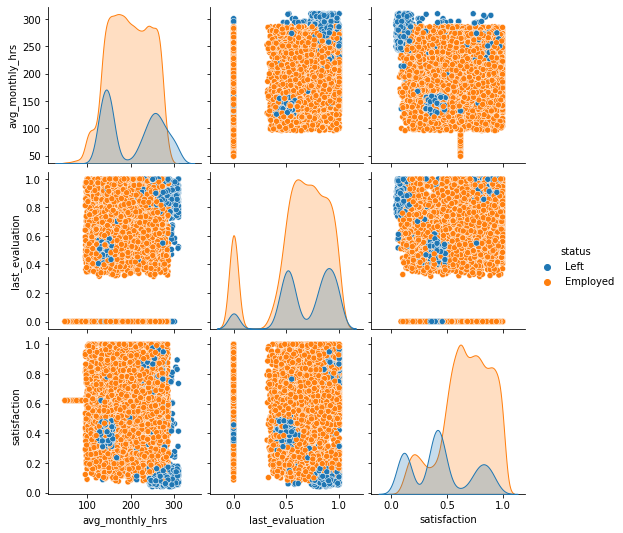

In [ ]:
sns.pairplot(data=Employee[['avg_monthly_hrs','filed_complaint', 'last_evaluation','satisfaction','status']], size=2.5, diag_kind='kde', hue = 'status')

**Observations**
- from the Above pair plot it is quite evident that there is high chances that employees whose working hours are high will leave the company and are least satisfied.

<a id=section704></a>
### 7.4 Age vs Status of employee
 

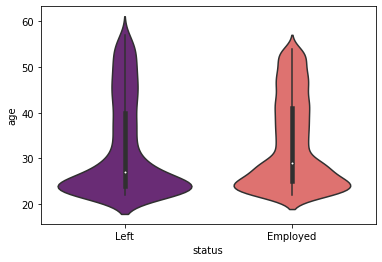

In [ ]:
sns.violinplot(data=Employee, x='status', y='age', palette='magma')

**Observations**
- Age seems to have no influence on the Employee leaving or staying in the company

<a id=section705></a>
### 7.5 Tenure vs Status of employee
 > 

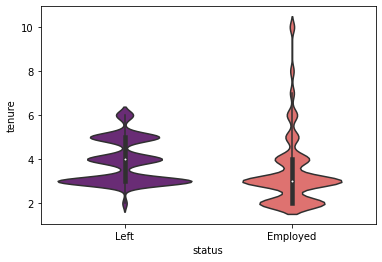

In [ ]:
sns.violinplot(data=Employee, x='status', y='tenure', palette='magma')

**Observations**
> Longer the Tenure, Higher the Chances that employee witll stay in the company. Employee with tenure between 2-5 years, there is high chances of them leaving the company

<a id=section706></a>
### 7.5 Marital Status vs Status of employee
 > 

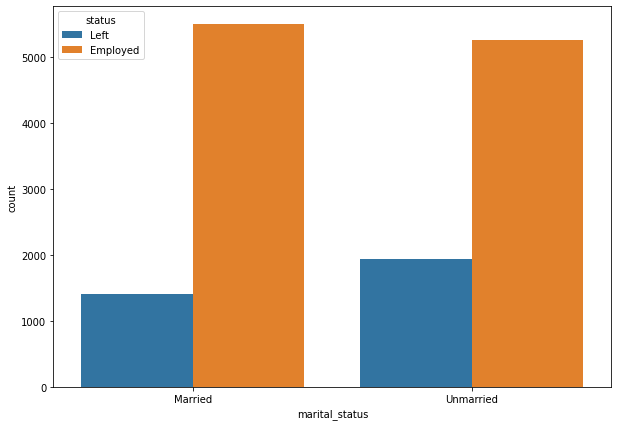

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x='marital_status',hue='status',data=Employee)

**Observations**
> Unmarried employees are more likely to leave the company

import pandas_profiling 
profile = data.profile_report(title="Auto Insurance Claim")
profile.to_file(output_file="Auto Insurance Claim_Data_profiling_before_preprocessing.html")

<a id=section8></a>
### 8.   Feature selection/extraction
At times some features do not contribute much to the accuracy of the model, in that case its better to discard those features.<br/> 
> - Employee Id is a unique key and it will drive the Status of employment. Let's drop this column by making this as Index column


In [ ]:
Employee.columns

Index(['avg_monthly_hrs', 'department', 'filed_complaint', 'last_evaluation',
       'n_projects', 'recently_promoted', 'salary', 'satisfaction', 'status',
       'tenure', 'employee_id', 'age', 'gender', 'marital_status'],
      dtype='object')

In [ ]:
Employee.set_index('employee_id')

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,age,gender,marital_status
employee_id,,,,,,,,,,,,,
124467,246.0,D00-SS,0,0.866838,6,0,medium,0.134415,Left,4.0,42,Female,Married
112210,134.0,D00-SS,0,0.555718,2,0,low,0.511041,Left,3.0,23,Female,Unmarried
126150,156.0,D00-SS,1,0.474082,2,0,medium,0.405101,Left,3.0,24,Female,Unmarried
125346,256.0,D00-SP,0,0.961360,6,0,low,0.152974,Left,4.0,51,Female,Married
113707,146.0,D00-SS,0,0.507349,2,0,medium,0.434845,Left,3.0,23,Female,Unmarried
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100833,141.0,D00-SS,0,0.537866,3,0,low,0.610841,Employed,3.0,29,Male,Unmarried
118090,168.0,D00-SS,0,0.643553,3,0,low,0.489559,Employed,3.0,24,Female,Unmarried
106064,257.0,D00-SP,0,0.000000,3,0,medium,0.944942,Employed,3.0,27,Male,Unmarried


In [ ]:
features = ['avg_monthly_hrs', 'department', 'filed_complaint', 'last_evaluation',
       'n_projects', 'recently_promoted', 'salary', 'satisfaction',
       'tenure', 'age', 'gender', 'marital_status']

In [ ]:
X = Employee[features]

In [ ]:
X.select_dtypes(include=['object'])

,department,filed_complaint,recently_promoted,salary,gender,marital_status
0,D00-SS,0,0,medium,Female,Married
1,D00-SS,0,0,low,Female,Unmarried
2,D00-SS,1,0,medium,Female,Unmarried
3,D00-SP,0,0,low,Female,Married
4,D00-SS,0,0,medium,Female,Unmarried
...,...,...,...,...,...,...
14111,D00-SS,0,0,low,Male,Unmarried
14112,D00-SS,0,0,low,Female,Unmarried
14113,D00-SP,0,0,medium,Male,Unmarried
14114,D00-IT,0,0,low,Male,Married


In [ ]:
## Define the categorical columns and generate dummies for it using pd.get_dummies
X = pd.get_dummies(X, X.select_dtypes(include=['object']).columns, drop_first=True)

In [ ]:
X

,avg_monthly_hrs,last_evaluation,n_projects,satisfaction,tenure,age,department_D00-ENG,department_D00-FN,department_D00-IT,department_D00-MN,department_D00-MT,department_D00-PD,department_D00-PR,department_D00-SP,department_D00-SS,department_D00-TP,filed_complaint_1,recently_promoted_1,salary_low,salary_medium,gender_Male,marital_status_Unmarried
0,246.0,0.866838,6,0.134415,4.0,42,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,134.0,0.555718,2,0.511041,3.0,23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
2,156.0,0.474082,2,0.405101,3.0,24,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1
3,256.0,0.961360,6,0.152974,4.0,51,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,146.0,0.507349,2,0.434845,3.0,23,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14111,141.0,0.537866,3,0.610841,3.0,29,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1
14112,168.0,0.643553,3,0.489559,3.0,24,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
14113,257.0,0.000000,3,0.944942,3.0,27,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1
14114,242.0,0.836603,4,0.740136,2.0,46,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
X.shape

(14116, 22)

<a id=section8></a>
# 8. Modeling

<a id=section501></a>
## 8.1 Define X and Y for Model Training

In [ ]:
Y = Employee['status'] ## Define the target variable

In [ ]:
Y.tail()

14111    Employed
14112    Employed
14113    Employed
14114    Employed
14115    Employed
Name: status, dtype: object

In [ ]:
# convert the Stauts  to binary values
Y.replace(to_replace=['Employed','Left'], value=[0,1],inplace=True) #Target variable should be 1 for Left and 0 for Employed

In [ ]:
Y.tail()

14111    0
14112    0
14113    0
14114    0
14115    0
Name: status, dtype: int64

In [ ]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: status, dtype: int64

<a id=section802></a>
## 8.2 Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_Test,y_train,y_test = train_test_split(X, Y, test_size=0.4, random_state=4)

<a id=section803></a>
## 8.3 Transformation/Scaling Train and Test Data

In [ ]:
#from sklearn import preprocessing
#X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
#X_Test=  preprocessing.StandardScaler().fit(X_Test).transform(X_Test)

In [ ]:
from sklearn import preprocessing
scaling_fit=preprocessing.StandardScaler().fit(X_train)
X_train = scaling_fit.transform(X_train)
X_Test=  scaling_fit.transform(X_Test)

In [ ]:
print("X train Shape : ",X_train.shape)
print("X test Shape : ",X_Test.shape)
print("Y train Shape : ",y_train.shape)
print("Y test Shape : ",y_test.shape)

X train Shape :  (8469, 22)
X test Shape :  (5647, 22)
Y train Shape :  (8469,)
Y test Shape :  (5647,)


<a id=section804></a>
## 8.4 LOGISTIC REGRESSION MODEL

In [ ]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
LogReg_model = LogisticRegression().fit(X_train,y_train)

In [ ]:
y_pred = LogReg_model.predict(X_Test)

In [ ]:

cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n",cnf_matrix)

print('Precision score for test data using logistic Regression is:', precision_score(y_test,y_pred))
print('Recall score for test data using logistic Regression is:',recall_score(y_test,y_pred))   
print('F1_score for test data using logistic Regression is:',f1_score(y_test, y_pred))


Confusion Matrix: 
 [[3972  313]
 [ 840  522]]
Precision score for test data using logistic Regression is: 0.6251497005988024
Recall score for test data using logistic Regression is: 0.3832599118942731
F1_score for test data using logistic Regression is: 0.4751934456076468


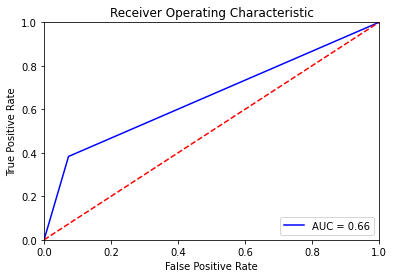

In [ ]:



probs = LogReg_model.predict_proba(X_Test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
## Define the Model Parameters dictory for all the models used for GRIDSearchCV. 
#This can help us run the multiple model with multiple parameters in a single iteration
model_params = {
  ##  'Naive Bayes':{
       ##        'model':GaussianNB(),
        ##       'params' : { }
        #   },
    'SVC': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20,30,40],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,20,30,40,50],
            'criterion':['gini', 'entropy']
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params':{'metric':['manhattan','chebyshev', 'euclidean'],'weights':['uniform', 'distance'],
                             'n_neighbors': range(1,20) }
        
        
    }
}

In [ ]:
scores = []
# Run the model model parameters defined in the above step. 
#This will run all the model using different parameters and return accuracy
for model_name, mp in model_params.items():
    print(model_name,mp)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, refit=True)
    clf.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
        
    })
    print('best_params', clf.best_params_)


SVC {'model': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'params': {'C': [1, 10, 20, 30, 40], 'kernel': ['rbf', 'linear', 'poly']}}
best_params {'C': 20, 'kernel': 'rbf'}
random_forest {'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'params': {'n_estimators': [1, 5, 10, 20, 30, 40, 

In [ ]:
df_Score = pd.DataFrame(scores,columns=['model','best_score','best_params']) # store the results in a Data frame
df_Score # print the score data frame to see the results of all the models

,model,best_score,best_params
0,SVC,0.951470,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.972725,"{'criterion': 'entropy', 'n_estimators': 30}"
2,KNN,0.935293,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei..."


## Random Forest and SVC got higher scores. Validating each of these

### Random Forest

In [ ]:

RF_model = RandomForestClassifier(n_estimators= 40).fit(X_train,y_train)
Train_pred=RF_model.predict(X_train)
y_pred=RF_model.predict(X_Test)
print('Accuracy_score for train data using Random Forest is:',accuracy_score(y_train, Train_pred))
print('Precision score for train data using Random Forest is:', precision_score(y_train,Train_pred))
print('Recall score for train data using Random Forest is:',recall_score(y_train,Train_pred))   
print('F1_score for train data using Random Forest is:',f1_score(y_train,Train_pred))
print('Accuracy_score for test data using Random Forest is:',accuracy_score(y_test, y_pred))
print('Precision score for test data using Random Forest is:', precision_score(y_test,y_pred))
print('Recall score for test data using Random Forest is:',recall_score(y_test,y_pred))   
print('F1_score for test data using Random Forest is:',f1_score(y_test, y_pred))

Accuracy_score for train data using Random Forest is: 0.9996457669146298
Precision score for train data using Random Forest is: 1.0
Recall score for train data using Random Forest is: 0.9984947315604616
F1_score for train data using Random Forest is: 0.9992467988953051
Accuracy_score for test data using Random Forest is: 0.9748539047281742
Precision score for test data using Random Forest is: 0.9841269841269841
Recall score for test data using Random Forest is: 0.9104258443465492
F1_score for test data using Random Forest is: 0.9458428680396642


### SVC

In [ ]:
SVC_model = SVC(C= 20, kernel= 'rbf').fit(X_train,y_train)
Train_pred=SVC_model.predict(X_train)
y_pred=SVC_model.predict(X_Test)
print('Accuracy_score for train data using SVC_model is:',accuracy_score(y_train, Train_pred))
print('Precision score for train data using SVC is:', precision_score(y_train,Train_pred))
print('Recall score for train data using SVC is:',recall_score(y_train,Train_pred))   
print('F1_score for train data using SVC_model is:',f1_score(y_train,Train_pred))
print('Accuracy_score for test data using SVC_model is:',accuracy_score(y_test, y_pred))
print('Precision score for test data using SVC_model is:', precision_score(y_test,y_pred))
print('Recall score for test data using SVC_model is:',recall_score(y_test,y_pred))   
print('F1_score for test data using SVC_model is:',f1_score(y_test, y_pred))

Accuracy_score for train data using SVC_model is: 0.9740229070728539
Precision score for train data using SVC is: 0.9493157627977699
Recall score for train data using SVC is: 0.9397892624184646
F1_score for train data using SVC_model is: 0.9445284921835603
Accuracy_score for test data using SVC_model is: 0.9541349389056136
Precision score for test data using SVC_model is: 0.9131086142322098
Recall score for test data using SVC_model is: 0.895007342143906
F1_score for test data using SVC_model is: 0.9039673711531331


In [ ]:
c =[1,10,15,20,30,40]  ## run SVC with different C values
score = []
start_time = time.time() # track the time required to run the alogithm
for i in c:
    model = SVC(gamma='auto', C= i, kernel = 'rbf')
    model.fit(X_train,y_train)
    ypred = model.predict(X_Test)
    Model_score = accuracy_score(y_test, ypred)
    model_precision = precision_score(y_test, ypred, average='weighted')
    # store C and its corresponding Score value in the model
    score.append({
        'C': i,
        'score': Model_score,
        'Precision' : model_precision
    })
end_time = time.time()
time2 = end_time-start_time
print(time2)  

9.371357202529907


## Observations:
- Both models are good. SVC however has lower difference in Recall value between train and test. Random Forest might be overfitting since there is higher difference between recall values between train and test. Looks like SVC would be better.

In [ ]:
df_score= pd.DataFrame(score,columns =['C', 'score'])

In [ ]:
df_score

,C,score
0,1,0.944041
1,10,0.953781
2,15,0.953427
3,20,0.954135
4,30,0.956083
5,40,0.956260


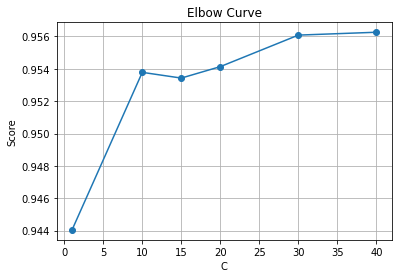

In [ ]:
# Plot the Elbow Curve to find out the best C
import pylab as pl
pl.plot((df_score.C),df_score.score,marker='o')
pl.grid()
pl.xlabel('C')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

### BEST C = 10 for SVC

In [ ]:
SVC_model = SVC(C= 10, kernel= 'rbf').fit(X_train,y_train) # best C from above is C=10
Train_pred=SVC_model.predict(X_train)
y_pred=SVC_model.predict(X_Test)
print('Accuracy_score for train data using SVC_model is:',accuracy_score(y_train, Train_pred))
print('Precision score for train data using SVC is:', precision_score(y_train,Train_pred))
print('Recall score for train data using SVC is:',recall_score(y_train,Train_pred))   
print('F1_score for train data using SVC_model is:',f1_score(y_train,Train_pred))
print('Accuracy_score for test data using SVC_model is:',accuracy_score(y_test, y_pred))
print('Precision score for test data using SVC_model is:', precision_score(y_test,y_pred))
print('Recall score for test data using SVC_model is:',recall_score(y_test,y_pred))   
print('F1_score for test data using SVC_model is:',f1_score(y_test, y_pred))

Accuracy_score for train data using SVC_model is: 0.9696540323532885
Precision score for train data using SVC is: 0.9383838383838384
Recall score for train data using SVC is: 0.9322629202207727
F1_score for train data using SVC_model is: 0.9353133652152026
Accuracy_score for test data using SVC_model is: 0.9537807685496724
Precision score for test data using SVC_model is: 0.9160997732426304
Recall score for test data using SVC_model is: 0.8898678414096917
F1_score for test data using SVC_model is: 0.9027932960893855


<a id=section6></a>
## 9 FINAL Model For Test Data
> Run the model on test data which  is shared by INSAID .compare the results with the actual results vs predicted results to measure the accurancy of our model

In [ ]:

# Import the test data which has 100 rows and use this data to predit the results
testdf = pd.read_csv('1007_TestData_INSAID.csv') #

FileNotFoundError: ignored

In [ ]:
# Convert this in Categorical column
testdf['recently_promoted'] = testdf['recently_promoted'].astype(str) 
testdf['filed_complaint'] = testdf['filed_complaint'].astype(str)
testdf['tenure']=testdf['tenure'].astype(float)
testdf['satisfaction']=testdf['satisfaction'].astype(float)
testdf.info()

In [ ]:
testdf.info()

In [ ]:
testdf.isnull().sum()

The Unseen data doesn't have the fields age, gender and marital status available. Lets where these feature stand in terms of importance


In [ ]:
#RF_model
feature_importances = pd.DataFrame(RF_model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

Based on the feature imporatnce, looks like age has got ~4% importance, marital status and gender has got less than 2% importance. Lets retrain the model on top 5 features which consist 86% of importance and drop the rest and seee how this performs.

In [ ]:
df_train = pd.DataFrame(i for i in X_train)
df_train.columns = X.columns

df_test = pd.DataFrame(i for i in X_Test)
df_test.columns = X.columns

In [ ]:
df_train=df_train[['satisfaction','n_projects','tenure','avg_monthly_hrs','last_evaluation']]
df_test=df_test[['satisfaction','n_projects','tenure','avg_monthly_hrs','last_evaluation']]

In [ ]:
scaling_fit=preprocessing.StandardScaler().fit(df_train)
df_train = scaling_fit.transform(df_train)
df_test=  scaling_fit.transform(df_test)

In [ ]:
print("------------SVC-----------------")
SVC_model = SVC(C= 10, kernel= 'rbf',probability=True).fit(df_train,y_train) # best C from above is C=10
Train_pred=SVC_model.predict(df_train)
y_pred=SVC_model.predict(df_test)
print('Precision score for train data using SVC is:', precision_score(y_train,Train_pred))
print('Recall score for train data using SVC is:',recall_score(y_train,Train_pred))   
print('F1_score for train data using SVC_model is:',f1_score(y_train,Train_pred))
print('Accuracy_score for train data using SVC_model is:',accuracy_score(y_train, Train_pred))
print('Precision score for test data using SVC_model is:', precision_score(y_test,y_pred))
print('Recall score for test data using SVC_model is:',recall_score(y_test,y_pred))   
print('F1_score for test data using SVC_model is:',f1_score(y_test, y_pred))
print('Accuracy_score for test data using SVC_model is:',accuracy_score(y_test, y_pred))


print("\n------------RandomForest-----------------")

RF_model = RandomForestClassifier().fit(df_train,y_train)
Train_pred=RF_model.predict(df_train)
y_pred=RF_model.predict(df_test)
print('Precision score for train data using Random Forest is:', precision_score(y_train,Train_pred))
print('Recall score for train data using Random Forest is:',recall_score(y_train,Train_pred))   
print('F1_score for train data using Random Forest is:',f1_score(y_train,Train_pred))
print('Accuracy_score for train data using Random Forest is:',accuracy_score(y_train, Train_pred))
print('Precision score for test data using Random Forest is:', precision_score(y_test,y_pred))
print('Recall score for test data using Random Forest is:',recall_score(y_test,y_pred))   
print('F1_score for test data using Random Forest is:',f1_score(y_test, y_pred))
print('Accuracy_score for test data using Random Forest is:',accuracy_score(y_test, y_pred))

Both models looks good based on the scores. Random forest however looks better with 97.7 accuracy and recall of 91.8

In [ ]:
# Mean value of Satisfaction on Original data set  0.621212
testdf['satisfaction'].fillna('0.621212', inplace=True)

In [ ]:
testdf.fillna({'filed_complaint': 0,'recently_promoted': 0, 'last_evaluation': 0}, inplace = True)
#testdf['department'].fillna('D00-SS', inplace=True)
testdf['tenure'].fillna('3.499357', inplace=True) 

In [ ]:
X_InsaidTest = testdf[['satisfaction','n_projects','tenure','avg_monthly_hrs','last_evaluation']]
#X_InsaidTest.set_index('employee_id')

In [ ]:
#X_InsaidTest.select_dtypes(include=['object'])
## Define the categorical columns and generate dummies for it using pd.get_dummies
#X_InsaidTest = pd.get_dummies(X_InsaidTest, X_InsaidTest['department','filed_complaint','recently_promoted','salary','gender','marital_status'], drop_first=True)
X_InsaidTest=  scaling_fit.transform(X_InsaidTest)

In [ ]:
testdf['Prediction_RF']=RF_model.predict(X_InsaidTest)
testdf['Prediction_ProbaLeft_RF']=RF_model.predict_proba(X_InsaidTest)[:,1]
testdf['Prediction_RF'].replace(to_replace=[0,1], value=['Employed','Left'],inplace=True) 
testdf.to_csv("Predictions_unseen.csv")